<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/05_simple_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simple Classification Problem

In a classification problem, we’re trying to predict which class a data
point belongs to.

Let’s say we have two classes of points: they are either red or blue. These are the
labels `(y)` of the points. 

Sure enough, we need to assign numeric values to them. We
could assign zero to red and one to blue. The class associated with zero is the
negative class, while one corresponds to the positive class.

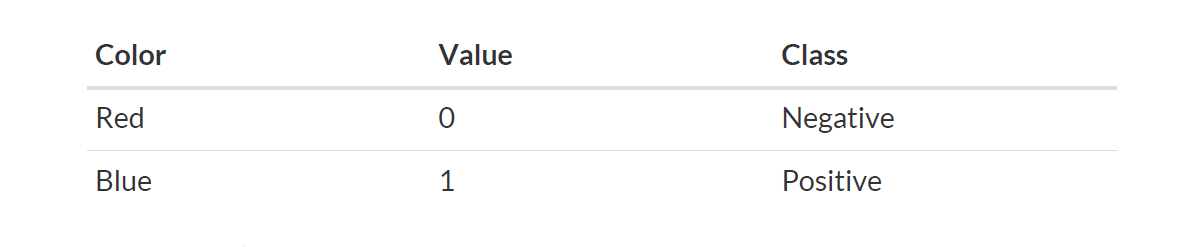

We can think of the logistic regression as the second simplest neural network
possible. It is pretty much the same as the linear regression, but with a sigmoid applied to the results of the output layer (`z`).

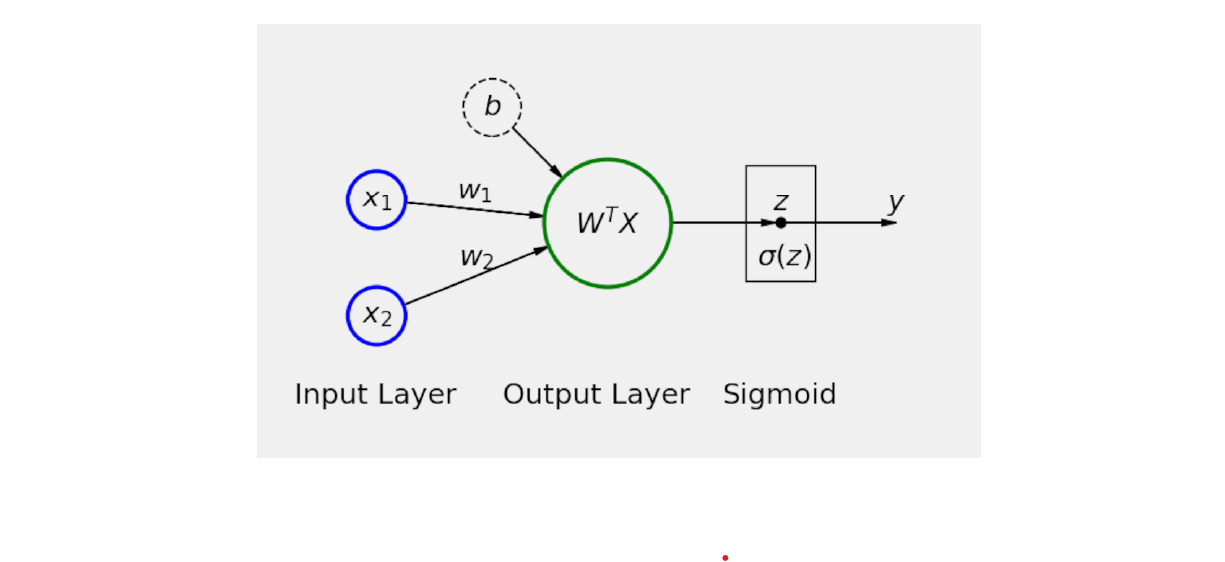

##Setup

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

Finished!


In [2]:
!wget https://github.com/rahiakela/deep-learning-research-and-practice/raw/main/deep-learning-with-pytorch-step-by-step/networks/linear_regression.py

--2022-11-18 04:08:57--  https://github.com/rahiakela/deep-learning-research-and-practice/raw/main/deep-learning-with-pytorch-step-by-step/networks/linear_regression.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rahiakela/deep-learning-research-and-practice/main/deep-learning-with-pytorch-step-by-step/networks/linear_regression.py [following]
--2022-11-18 04:08:57--  https://raw.githubusercontent.com/rahiakela/deep-learning-research-and-practice/main/deep-learning-with-pytorch-step-by-step/networks/linear_regression.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621 (7.4K) [text/plain]

In [3]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from linear_regression import LinearRegression

##Data Generation

Let’s make the data a bit more interesting by using two features ($x_1$ and $x_2$) this time. 

We’ll use Scikit-Learn’s `make_moons` to generate a toy dataset with 100 data
points. We will also add some Gaussian noise and set a random seed to ensure
reproducibility.

In [4]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13) 

>Remember, the split should always be the first thing you do - no
preprocessing, no transformations, nothing happens before the
split.

Next, we’ll standardize the features using Scikit-Learn’s `StandardScaler`:

In [5]:
st_scaler = StandardScaler()
st_scaler.fit(x_train)  # use only the training set to fit

# then use its transform method to apply the preprocessing step to all datasets
x_train = st_scaler.transform(x_train)
x_val = st_scaler.transform(x_val)

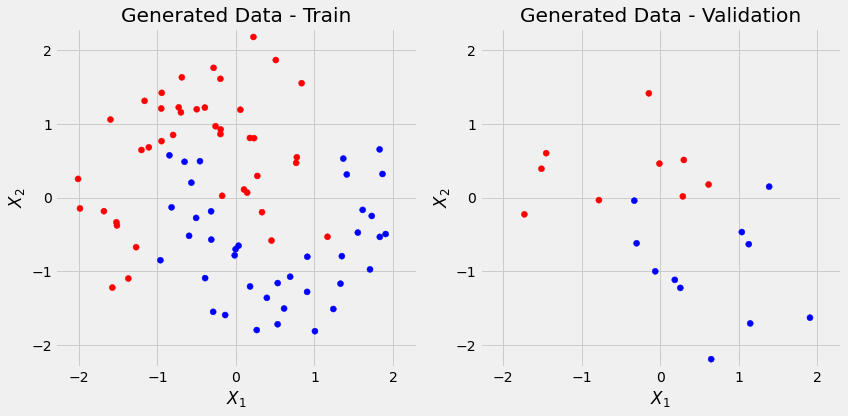

In [ ]:
fig = figure1(x_train, y_train, x_val, y_val)

##Data Preparation

As usual, the data preparation
step converts Numpy arrays into PyTorch tensors, builds TensorDatasets for them,
and creates the corresponding data loaders.

In [6]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(x_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Logistic Regression Model

How would a linear regression model
with two features look like?

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

There is one obvious problem with the model above: our `labels (y)` are discrete;
that is, they are either zero or one; no other value is allowed. We need to change
the model slightly to adapt it to our purposes…

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

To make our lives easier, let’s give the right-hand side of the equation above a
name: `logit (z)`.

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

There is one fundamental difference between them: there is no error
term (epsilon).

If there is no error term, where does the uncertainty come from?

That’s the role of the probability: instead of assigning a data
point to a discrete label (zero or one), we’ll compute the probability of a data point
belonging to the positive class.

We would like to have large positive logit values assigned
to higher probabilities (of being in the positive class) and large negative logit values
assigned to lower probabilities (of being in the positive class).

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$




###Odd Ratio

Let’s imagine we are betting on the winner of the World Cup’s final. There are two
countries: A and B. 

Country A is the favorite: it has a 75% chance of winning.So, Country B has only a 25% chance of winning. 

If you bet on Country A, your chances
of winning, that is, your odds (in favor) are 3 to 1 (75 to 25). If you decide to test
your luck and bet on Country B, your chances of winning, that is, your odds (in
favor) are 1 to 3 (25 to 75), or 0.33 to 1.

The odds ratio is given by the ratio between the probability of success (`p`) and the
probability of failure (`q`):

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$



In [ ]:
def odds_ratio(prob):
  return prob / (1 - prob)

In [ ]:
p = .75
q = 1 - p

odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

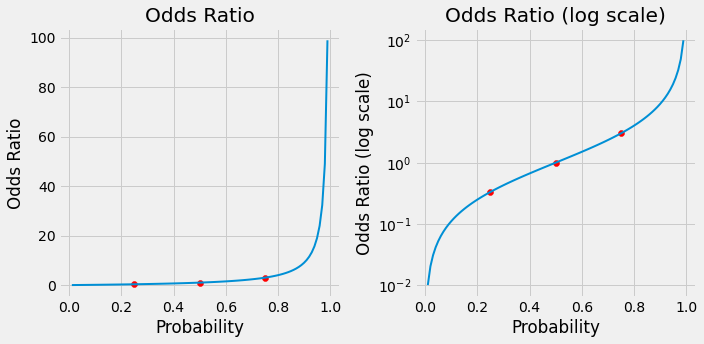

In [ ]:
fig = figure2(p)

###Log Odds Ratio

By taking the logarithm of the odds ratio, the function is not only symmetrical, but
it also maps probabilities into real numbers, instead of only the positive ones:

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In [ ]:
def log_odds_ratio(prob):
  return np.log(prob / (1 - prob))

In [ ]:
p = .75
q = 1 - p

log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

As expected, probabilities that add up to `100%` (like `75%` and `25%`) correspond to log odds ratios that are the same in absolute value.

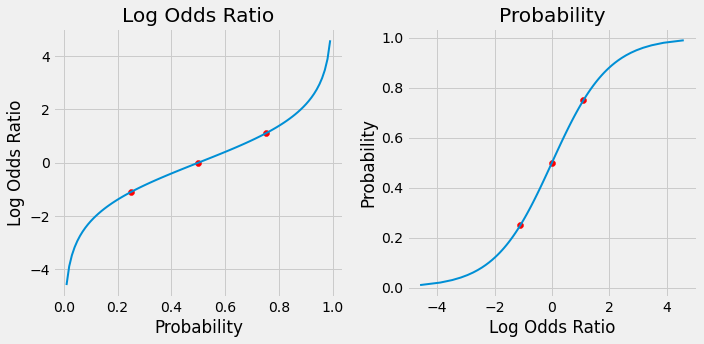

In [ ]:
fig = figure3(p)

If we flip the horizontal and vertical axes (right plot), we are inverting the function, thus mapping each log odds ratio into a probability.

###From Logits to Probabilities

Clearly, our logits are log odds ratios :-) 

Sure, drawing conclusions like this is not
very scientific, but the purpose of this exercise is to illustrate how the results of a
regression, represented by the logits `(z)`, get to be mapped into probabilities.

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

Let’s work this equation out a bit, inverting, rearranging, and simplifying some
terms to isolate `p`:

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

That’s a sigmoid function! It is the inverse of the log odds
ratio.

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [ ]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [ ]:
p = .75
q = 1 - p

sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

###Sigmoid

PyTorch provides
two different ways of using a sigmoid: `torch.sigmoid` and `nn.Sigmoid`.

In [ ]:
# The first one is a simple function, but taking a tensor as input and returning another tensor
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

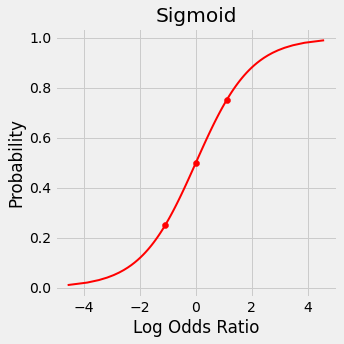

In [ ]:
fig = figure4(p)

###Logistic Regression

Given two features, $x_1$ and $x_2$, the model will fit a linear regression such that its
outputs are logits (`z`), which are converted into probabilities using a sigmoid function.

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

Now let’s use the Sequential model to build our logistic regression.

In [7]:
torch.manual_seed(42)

model1 = nn.Sequential()
model1.add_module("linear", nn.Linear(2, 1))
model1.add_module("sigmoid", nn.Sigmoid())

print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


Let's understand its vectorized representations.

Dataset:

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

Model:

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

##Loss